### Import Libraries and Dataset

In [1]:
from Functions import get_feature_ranking, RMSE, train_model, wrapper_feature_selector
from pyspark import SparkContext
from spark_sklearn import GridSearchCV
from pylab import *

import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from time import time
from math import sqrt
from sklearn.ensemble import ExtraTreesRegressor

from matplotlib import pyplot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

# Import train + test features (after data processing)
data = pd.read_csv('Trees_features.csv')
print('n_features:', len(data.iloc[0]))
print('n_samples:', len(data))
data.head()

n_features: 23
n_samples: 953


,Id,accommodates,bathrooms,bedrooms,beds,cleaning_fee,minimum_nights,number_of_reviews,review_scores_location,instant_bookable,...,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,area_Manly,area_Pittwater,area_Warringah
0,570,0.052367,-0.577122,0.141696,-0.206717,-0.881690,-0.234696,-0.436781,0.90309,0,...,0,1,0,0,1,0,0,0,0,1
1,571,-0.690463,-0.577122,-0.827405,-0.901215,-0.178438,-0.234696,0.170065,1.00000,0,...,0,0,1,0,1,0,0,1,0,0
2,572,0.052367,-0.577122,-0.827405,-0.206717,-0.881690,0.205502,-0.436781,1.00000,0,...,0,1,0,0,0,0,1,0,0,1
3,573,-0.319048,-0.577122,0.141696,-0.901215,-0.037788,-0.322735,-0.301927,0.90309,0,...,0,1,0,0,0,0,1,1,0,0
4,574,0.052367,-0.577122,0.141696,-0.206717,-0.881690,-0.146656,-0.504209,1.00000,0,...,0,1,0,0,0,1,0,0,0,1


In [2]:
# Import train labels
Y_train = pd.read_csv('Trees_labels.csv')
print('n_samples:', len(Y_train))
Y_train = Y_train.iloc[:,1].values

n_samples: 383


In [3]:
# Split training and test data
train_data  = data.iloc[:383,1:]
X_train = train_data.values
test_data = data.iloc[383:,1:]
X_test = test_data.values
X_train.shape

(383, 22)

### Define feature ranking plot function

In [4]:
def plot_features_ranking(feature_importances, model, selected_features=np.arange(0,22).tolist()):
    #!/usr/bin/env python
    # make a horizontal bar chart
    val = feature_importances  # the bar lengths
    pos = train_data.columns[selected_features] # the bar centers on the y axis

    figure(1,figsize=(10, 8))
    barh(pos,val, align='center')
    yticks(pos, data.columns[1:])
    xlabel('Importance')
    title(model)
    grid(True) 
    show()

### Pre-Tuning Recursive Feature Selection 

In [3]:
etrees = ExtraTreesRegressor(n_jobs=-1,random_state=100) 
selected_features, rmse = wrapper_feature_selector(X_train,Y_train,etrees)   
print('Selected Features:',str(selected_features))

Selected Features: [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


### Parameters Tuning

In [5]:
from sklearn.pipeline import Pipeline
pipe = pipe = Pipeline([
    
    ('extrees', ExtraTreesRegressor())
])
pipe

Pipeline(memory=None,
     steps=[('extrees', ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [6]:
%%time
sc = SparkContext()

param_grid = [{"extrees__max_features": [5,6,7,8,9,10,11],
              "extrees__n_estimators": [20,30,40,50,60,70],
              "extrees__random_state": [100],
              "extrees__max_depth": [2,3,4,5,6,7,8,9,10,11],
              "extrees__n_jobs": [-1],
              "extrees__bootstrap": [True]
        }]

gs = GridSearchCV(sc, pipe, param_grid, cv=10, scoring=make_scorer(RMSE,greater_is_better=False), verbose=1) 
gs.fit(X_train[:,selected_features],Y_train.reshape(-1,))
print('Best Parameters: ',gs.cv_results_['params'][gs.best_index_])
sc.stop()

Fitting 10 folds for each of 420 candidates, totalling 4200 fits
Best Parameters:  {'extrees__bootstrap': True, 'extrees__max_depth': 8, 'extrees__max_features': 7, 'extrees__n_estimators': 40, 'extrees__n_jobs': -1, 'extrees__random_state': 100}
CPU times: user 596 ms, sys: 175 ms, total: 771 ms
Wall time: 6min 49s


In [7]:
print("Best RMSE:", str(gs.cv_results_['mean_test_score'][gs.best_index_]))


Best RMSE: -67.30846916511219


### Recursive Feature Selection

In [16]:
%%time
# Feature Selection
etrees = ExtraTreesRegressor(bootstrap=True,max_depth=8,max_features=7,n_estimators=40,n_jobs=-1,random_state=100) 

selected_features, rmse = wrapper_feature_selector(X_train,Y_train,etrees,subset=selected_features)   
print('Selected Features:',str(selected_features))
print('Train RMSE: {:0.2f}'.format(rmse))


Selected Features: [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Train RMSE: 67.31
CPU times: user 16.7 s, sys: 3.38 s, total: 20.1 s
Wall time: 1min 16s


### Selected Features Ranking

XGB Features Ranking: [11, 3, 10, 0, 1, 2, 7, 18, 4, 17, 15, 5, 6, 16, 13, 14, 8, 12, 9]


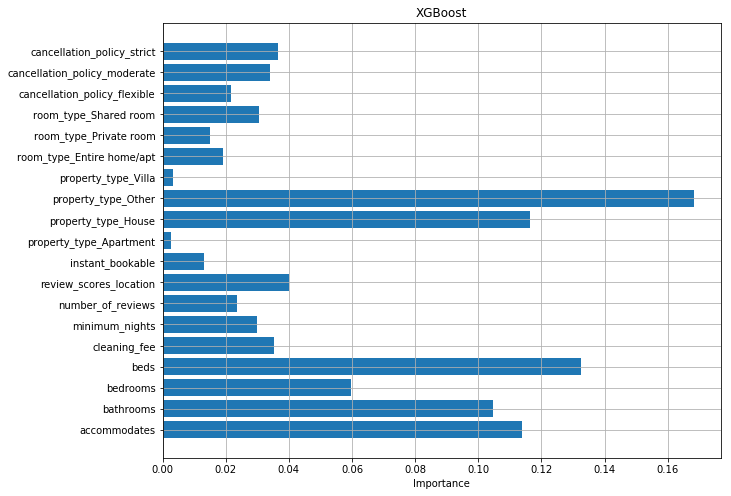

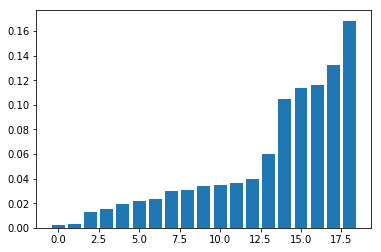

In [67]:
etrees = ExtraTreesRegressor(bootstrap=True,oob_score=True,max_depth=8,max_features=7,n_estimators=40,n_jobs=-1,random_state=100) 
etrees.fit(X_train[:,selected_features],Y_train)
etrees_features = get_feature_ranking(etrees.feature_importances_)
print('XGB Features Ranking:',etrees_features)
plot_features_ranking(etrees.feature_importances_, 'XGBoost', selected_features)
# plot
pyplot.bar(range(len(etrees.feature_importances_)), sorted(etrees.feature_importances_))
pyplot.show()


### Prediction

In [50]:
etrees = ExtraTreesRegressor(bootstrap=True,oob_score=True,max_depth=8,max_features=7,n_estimators=40,n_jobs=-1,random_state=100) 
etrees.fit(X_train[:,selected_features],Y_train)
Y_pred = etrees.predict(X_test[:,selected_features])
# Output to csv file
from pandas import DataFrame
y_p = {'id': np.arange(0,570),'price': Y_pred.reshape(-1,)}
y_p = DataFrame(y_p)
y_p.to_csv('ExtraTrees.csv', index=False)
